In [1]:
# Core utilities moved to fire_model package
import numpy as np
import matplotlib.pyplot as plt
from fire_model.ca import FireEnv, FireState, CAFireModel
from fire_model.boundary import (
    FireBoundary,
    between_boundaries_mask,
    candidates_from_mask,
    extract_fire_boundary,
    plot_fire_boundary,
)
from fire_model.harmonic import (
    HarmonicStripMap,
    BoundaryMap,
    build_harmonic_strip_map_uniform,
    plot_strip_map,
    sd_to_xy_theta,
    build_boundary_map,
    plot_boundary_correspondence,
)
from fire_model.bo import (
    RetardantDropBayesOpt,
    SearchGridProjector,
    TiedXYFiMatern,
    expected_improvement,
)

import fire_model.bo as bo

### Environment Set-Up

In [2]:
# Grid / domain
nx = ny = 120
domain_km = 5

# Time discretisation (used for indexing time-varying wind and for FireState.t)
dt_s = 5.0

# Fire physics parameters
burn_time_s0 = 15 * 60         # how long a cell stays "burning" after ignition (seconds)
ros_mps = 0.2                 # baseline ROS (m/s)

# Retardant parameters
retardant_half_life_s = 2400.0 # seconds (e.g., 40 minutes)
retardant_k = 1.25             # attenuation strength exp(-k * retardant)

# Spatial maps
xs = np.linspace(-1.0, 1.0, nx)[:, None]
ys = np.linspace(-1.0, 1.0, ny)[None, :]
fuel = 0.7 + 0.9 * np.exp(-3.0 * (xs**2 + ys**2))
fuel = np.ones((nx, ny), dtype=float)
value = 1.0 + 3.0 * np.exp(-4.0 * ((xs - 0.2) ** 2 + (ys + 0.1) ** 2))
value = np.ones((nx, ny), dtype=float)

# Constant wind: mild south-westerly
wind=np.zeros((nx, ny, 2), dtype=float)
wind[..., 0] = 0
wind[..., 1] = 15.0  # 5 m/s northwards

env = FireEnv(
    grid_size=(nx, ny),
    domain_km=domain_km,
    wind=wind,
    fuel=fuel,
    value=value,
    dt_s=dt_s,
    burn_time_s0=burn_time_s0,
    retardant_half_life_s=retardant_half_life_s,
    retardant_k=retardant_k,
    ros_mps=ros_mps,
    # wind_coeff is unused by the Finsler model, but can exist in the env
    wind_coeff=0.6,
    diag=True,
    avoid_burning_drop=True,
    avoid_drop_p_threshold=0.05,
)

ca_model = CAFireModel(env,seed=42)

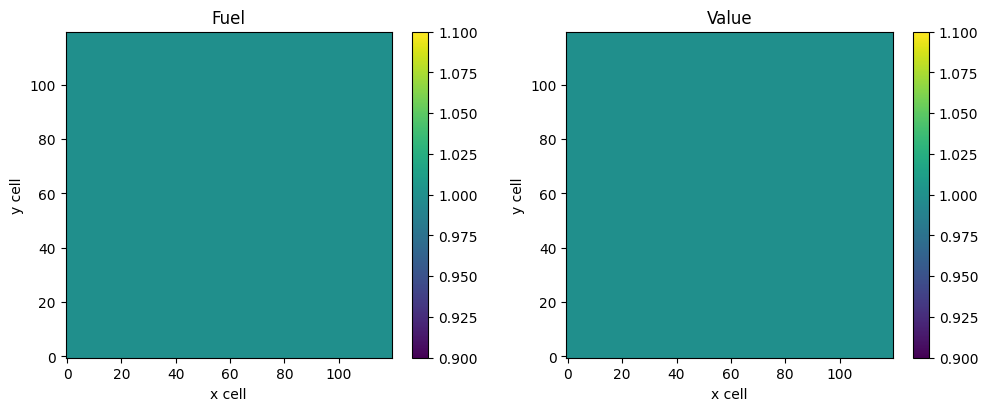

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)

im0 = ax[0].imshow(fuel.T, origin="lower", aspect="equal")
ax[0].set_title("Fuel")
ax[0].set_xlabel("x cell"); ax[0].set_ylabel("y cell")
fig.colorbar(im0, ax=ax[0], fraction=0.046)

im1 = ax[1].imshow(value.T, origin="lower", aspect="equal")
ax[1].set_title("Value")
ax[1].set_xlabel("x cell"); ax[1].set_ylabel("y cell")
fig.colorbar(im1, ax=ax[1], fraction=0.046)

plt.show()

### Ignition and Search Domain

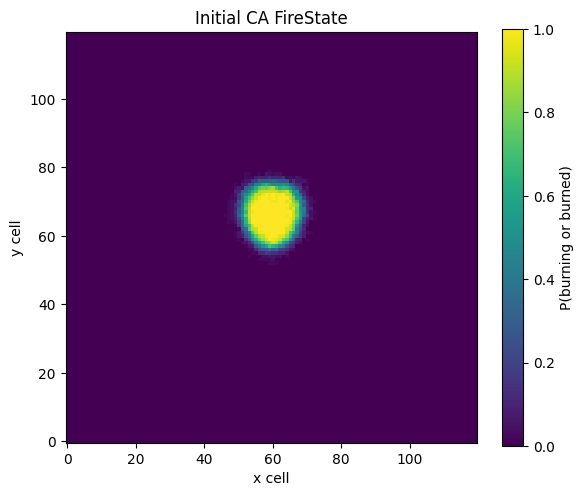

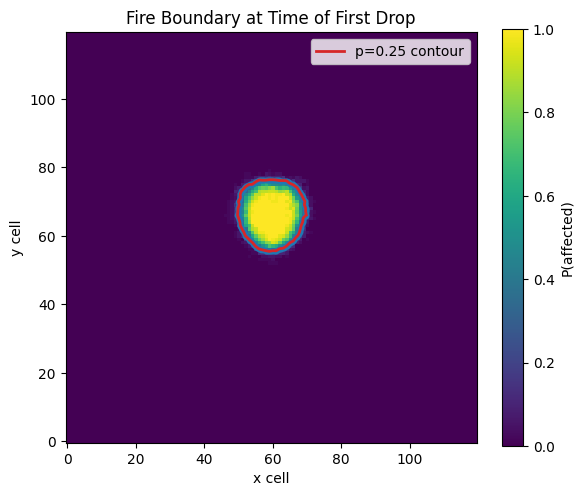

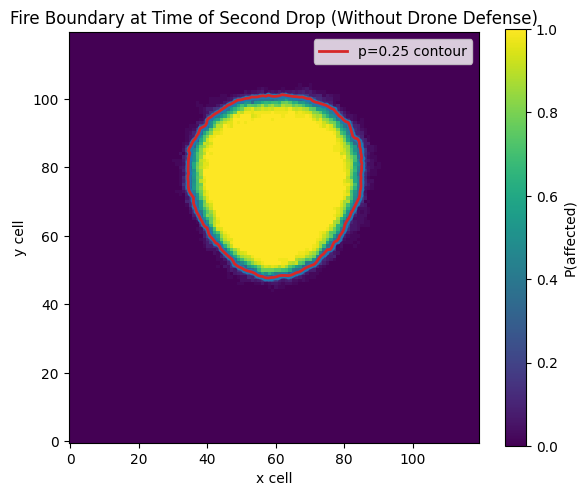

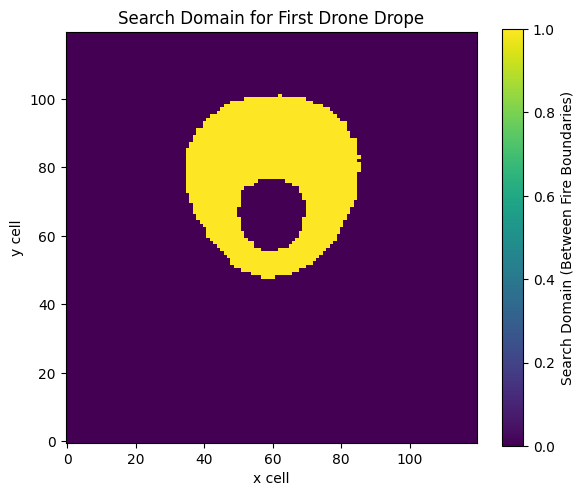

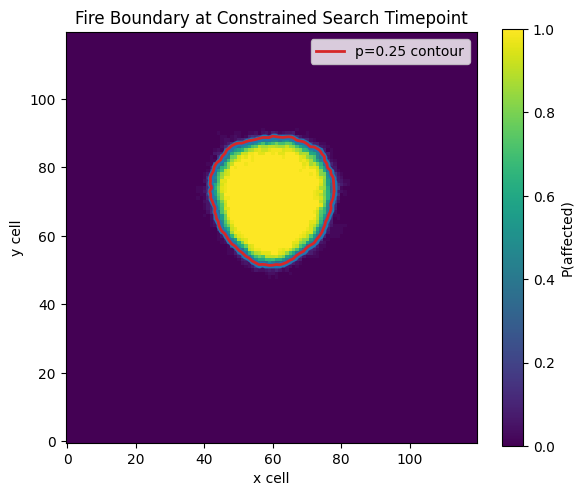

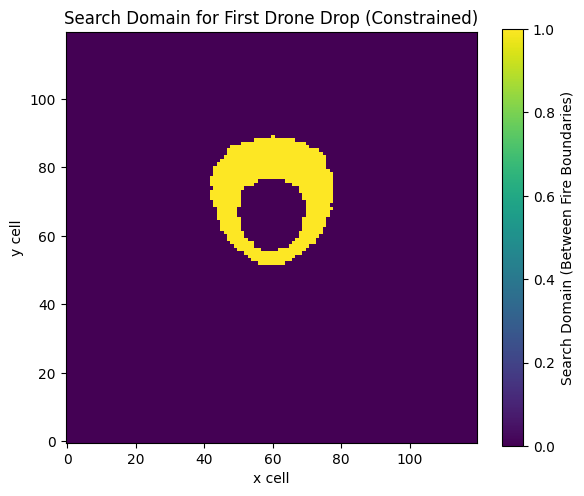

In [4]:
# Ignition and time until drones reach the fire
ignition_center = (nx // 2, ny // 2)
ignition_radius_km = 0.01
time_to_first_drop = 100.0  # 1 minute to response
time_to_second_drop = 240.0 # 2 minutes later 
search_space_time = (time_to_second_drop - time_to_first_drop)//2

# Initial Evolution
init_firestate_ca = ca_model.simulate_from_ignition(
    center=ignition_center,
    radius_km=ignition_radius_km,
    n_sims=50,
    T=time_to_first_drop
)

ca_model.plot_firestate(init_firestate_ca,title="Initial CA FireState")

# Visualising the boundary
init_boundary = extract_fire_boundary(
    init_firestate_ca,  
    K=200,
    p_boundary=0.25,
    field="affected",
    anchor="max_x",
    ccw=True
)

plot_fire_boundary(
    init_firestate_ca,
    init_boundary,
    field="affected",
    title="Fire Boundary at Time of First Drop"
)

# Visualising the search domain
second_firestate_ca = ca_model.simulate_from_firestate(
    init_firestate=init_firestate_ca,
    T=time_to_second_drop - time_to_first_drop, # assumes we want to search the whole space between first & second drop (smaller might be better in practice)
    n_sims=50,
)

second_boundary = extract_fire_boundary(
    second_firestate_ca,  
    K=200,
    p_boundary=0.25,
    field="affected",
    anchor="max_x",
    ccw=True
)

plot_fire_boundary(
    second_firestate_ca,
    second_boundary,
    field="affected",
    title="Fire Boundary at Time of Second Drop (Without Drone Defense)"
)

between_boundaries_mask = ca_model.discretise_between_boundaries(init_boundary, second_boundary)

ca_model.plot_search_domain(between_boundaries_mask,title="Search Domain for First Drone Drope")

# Extra constrained search space

constrained_firestate_ca = ca_model.simulate_from_firestate(
    init_firestate=init_firestate_ca,
    T=search_space_time, # assumes we want to search the whole space between first & second drop (smaller might be better in practice)
    n_sims=50,
)

constrained_boundary = extract_fire_boundary(
    constrained_firestate_ca,  
    K=200,
    p_boundary=0.25,
    field="affected",
    anchor="max_x",
    ccw=True
)

plot_fire_boundary(
    constrained_firestate_ca,
    constrained_boundary,
    field="affected",
    title="Fire Boundary at Constrained Search Timepoint"
)

between_boundaries_mask = ca_model.discretise_between_boundaries(init_boundary, constrained_boundary)

ca_model.plot_search_domain(between_boundaries_mask,title="Search Domain for First Drone Drop (Constrained)")

### Bayesian Optimisation Set-Up

In [5]:
from fire_model.bo import RetardantDropBayesOpt

constrained_search_time = (time_to_second_drop - time_to_first_drop)*2//3

drop_opt = RetardantDropBayesOpt(
    fire_model=ca_model,
    init_firestate=init_firestate_ca,
    n_drones=4,
    evolution_time_s=time_to_second_drop-time_to_first_drop,
    search_grid_evolution_time_s=constrained_search_time,
    n_sims=50,
    fire_boundary_probability=0.25,
)

### Bayesian Optimisation (Random Mask Initialisation)

[BO] Search grid set up with 529 valid cells in grid.


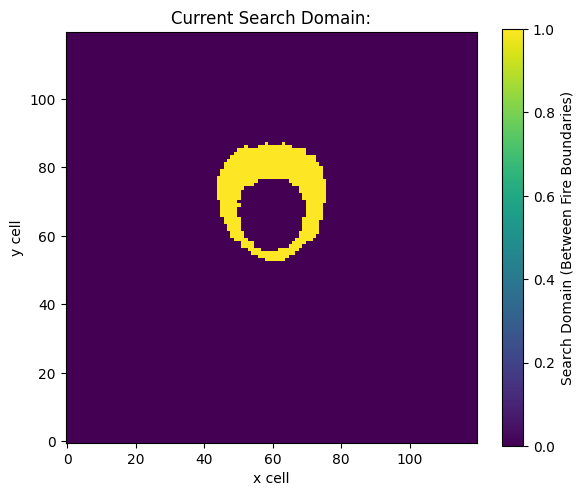

[BO] init: n_init=50, dim=12, n_cells=529
[BO] init: best_y=1.27139, mean_y=1.51143, std_y=0.0954712


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 001/150 | y_next=1.45764 | best_y=1.27139 (no-improve) | EI_max=0.00189 | mu=1.39429 | std=0.0827
      proposed (x,y,phi) per drone:
      [[44.         77.          1.45664784]
 [52.         86.          0.11658977]
 [63.         87.          5.00183973]
 [72.         83.          0.60185931]]
      gp.kernel_ = 1.02**2 * TiedXYFiMatern(lx=0.105, ly=0.127, lphi=2.29, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 010/150 | y_next=1.5126 | best_y=1.27139 (no-improve) | EI_max=0.000303 | mu=1.44942 | std=0.0819
      proposed (x,y,phi) per drone:
      [[47.         82.          0.26785557]
 [49.         84.          5.51026771]
 [63.         77.          3.34353576]
 [69.         85.          1.31936371]]
      gp.kernel_ = 0.713**2 * TiedXYFiMatern(lx=0.0992, ly=0.139, lphi=2.97, nu=2.5) + WhiteKernel(noise_level=0.488)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 020/150 | y_next=1.43128 | best_y=1.27139 (no-improve) | EI_max=0.000182 | mu=1.44201 | std=0.0742
      proposed (x,y,phi) per drone:
      [[44.         71.          3.45900075]
 [52.         86.          4.99754427]
 [58.         87.          4.24715124]
 [75.         76.          6.04666898]]
      gp.kernel_ = 0.671**2 * TiedXYFiMatern(lx=0.116, ly=0.122, lphi=4.16, nu=2.5) + WhiteKernel(noise_level=0.555)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packa

[BO] iter 030/150 | y_next=1.50375 | best_y=1.27139 (no-improve) | EI_max=0.000171 | mu=1.4477 | std=0.0757
      proposed (x,y,phi) per drone:
      [[44.         71.          4.4399043 ]
 [52.         86.          5.5221026 ]
 [74.         80.          1.93206127]
 [74.         80.          4.08027829]]
      gp.kernel_ = 0.709**2 * TiedXYFiMatern(lx=0.162, ly=0.168, lphi=1e+03, nu=2.5) + WhiteKernel(noise_level=0.603)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/

[BO] iter 040/150 | y_next=1.44472 | best_y=1.27139 (no-improve) | EI_max=0.000139 | mu=1.44675 | std=0.0736
      proposed (x,y,phi) per drone:
      [[44.         77.          6.16389276]
 [46.         81.          5.4665227 ]
 [63.         87.          4.27200144]
 [75.         76.          0.78245138]]
      gp.kernel_ = 0.676**2 * TiedXYFiMatern(lx=0.188, ly=0.21, lphi=923, nu=2.5) + WhiteKernel(noise_level=0.684)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/

[BO] iter 050/150 | y_next=1.39969 | best_y=1.27139 (no-improve) | EI_max=9.24e-05 | mu=1.44587 | std=0.0701
      proposed (x,y,phi) per drone:
      [[44.         77.          2.76389718]
 [52.         86.          4.2212098 ]
 [58.         79.          1.20116946]
 [72.         83.          1.33137101]]
      gp.kernel_ = 0.748**2 * TiedXYFiMatern(lx=0.195, ly=0.212, lphi=1e+03, nu=2.5) + WhiteKernel(noise_level=0.652)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/

[BO] iter 060/150 | y_next=1.4559 | best_y=1.27139 (no-improve) | EI_max=0.000114 | mu=1.44078 | std=0.0699
      proposed (x,y,phi) per drone:
      [[45.         66.          0.41276063]
 [50.         85.          1.79473077]
 [69.         85.          3.91334938]
 [75.         76.          0.48423514]]
      gp.kernel_ = 0.748**2 * TiedXYFiMatern(lx=0.185, ly=0.22, lphi=22.6, nu=2.5) + WhiteKernel(noise_level=0.643)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/

[BO] iter 070/150 | y_next=1.41715 | best_y=1.27139 (no-improve) | EI_max=7.05e-05 | mu=1.44497 | std=0.0678
      proposed (x,y,phi) per drone:
      [[44.         76.          4.22071104]
 [49.         84.          2.3036825 ]
 [58.         85.          5.36970539]
 [75.         76.          3.93614458]]
      gp.kernel_ = 0.778**2 * TiedXYFiMatern(lx=0.214, ly=0.239, lphi=54.3, nu=2.5) + WhiteKernel(noise_level=0.668)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 080/150 | y_next=1.39042 | best_y=1.27139 (no-improve) | EI_max=5.59e-05 | mu=1.44789 | std=0.0672
      proposed (x,y,phi) per drone:
      [[44.         71.          2.74132766]
 [50.         85.          1.99981557]
 [52.         78.          5.42012543]
 [74.         80.          3.85740699]]
      gp.kernel_ = 0.828**2 * TiedXYFiMatern(lx=0.241, ly=0.25, lphi=33.8, nu=2.5) + WhiteKernel(noise_level=0.634)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/

[BO] iter 090/150 | y_next=1.5499 | best_y=1.27139 (no-improve) | EI_max=7.44e-05 | mu=1.43481 | std=0.0648
      proposed (x,y,phi) per drone:
      [[44.         71.          4.95200841]
 [50.         85.          0.7391493 ]
 [54.         78.          0.65782091]
 [74.         80.          3.07212745]]
      gp.kernel_ = 0.874**2 * TiedXYFiMatern(lx=0.27, ly=0.253, lphi=1e+03, nu=2.5) + WhiteKernel(noise_level=0.633)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/

[BO] iter 100/150 | y_next=1.47274 | best_y=1.27139 (no-improve) | EI_max=5.71e-05 | mu=1.44274 | std=0.0657
      proposed (x,y,phi) per drone:
      [[4.40000000e+01 7.10000000e+01 1.65258579e+00]
 [5.20000000e+01 8.40000000e+01 4.00398270e+00]
 [6.00000000e+01 8.30000000e+01 3.33762723e-01]
 [7.20000000e+01 8.30000000e+01 7.12680965e-02]]
      gp.kernel_ = 0.896**2 * TiedXYFiMatern(lx=0.3, ly=0.284, lphi=1e+03, nu=2.5) + WhiteKernel(noise_level=0.656)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/

[BO] iter 110/150 | y_next=1.45226 | best_y=1.27139 (no-improve) | EI_max=6.14e-05 | mu=1.43949 | std=0.0651
      proposed (x,y,phi) per drone:
      [[45.         77.          1.01806094]
 [52.         86.          4.47494196]
 [58.         77.          1.47220737]
 [72.         83.          2.38795114]]
      gp.kernel_ = 0.914**2 * TiedXYFiMatern(lx=0.284, ly=0.27, lphi=1e+03, nu=2.5) + WhiteKernel(noise_level=0.651)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/

[BO] iter 120/150 | y_next=1.46806 | best_y=1.27139 (no-improve) | EI_max=3.27e-05 | mu=1.44834 | std=0.0641
      proposed (x,y,phi) per drone:
      [[46.         81.          5.90698624]
 [56.         86.          5.64393837]
 [60.         79.          3.4593636 ]
 [74.         80.          5.96516345]]
      gp.kernel_ = 0.958**2 * TiedXYFiMatern(lx=0.304, ly=0.279, lphi=1e+03, nu=2.5) + WhiteKernel(noise_level=0.654)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/

[BO] iter 130/150 | y_next=1.3784 | best_y=1.27139 (no-improve) | EI_max=3.84e-05 | mu=1.44129 | std=0.0628
      proposed (x,y,phi) per drone:
      [[45.         66.          0.69361443]
 [52.         86.          4.95412922]
 [58.         80.          1.46666007]
 [74.         80.          0.44622404]]
      gp.kernel_ = 0.988**2 * TiedXYFiMatern(lx=0.316, ly=0.282, lphi=1e+03, nu=2.5) + WhiteKernel(noise_level=0.654)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/

[BO] iter 140/150 | y_next=1.51337 | best_y=1.27139 (no-improve) | EI_max=3.12e-05 | mu=1.44299 | std=0.0621
      proposed (x,y,phi) per drone:
      [[44.         71.          1.16680997]
 [52.         86.          1.9005664 ]
 [54.         75.          4.39402257]
 [72.         83.          0.86674411]]
      gp.kernel_ = 0.994**2 * TiedXYFiMatern(lx=0.279, ly=0.264, lphi=1e+03, nu=2.5) + WhiteKernel(noise_level=0.648)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/

[BO] iter 150/150 | y_next=1.48306 | best_y=1.27139 (no-improve) | EI_max=2.25e-05 | mu=1.4487 | std=0.0621
      proposed (x,y,phi) per drone:
      [[44.         71.          4.60279293]
 [58.         87.          3.12790745]
 [66.         75.          0.74712113]
 [72.         83.          5.35016539]]
      gp.kernel_ = 1.01**2 * TiedXYFiMatern(lx=0.289, ly=0.283, lphi=1e+03, nu=2.5) + WhiteKernel(noise_level=0.665)
[BO] done: best_y=1.27139
[BO] best params:
[[4.80000000e+01 7.70000000e+01 5.27062402e+00]
 [6.50000000e+01 8.30000000e+01 1.77160544e+00]
 [7.00000000e+01 5.90000000e+01 2.73728309e+00]
 [7.00000000e+01 6.60000000e+01 2.14600399e-03]]


In [6]:
best_theta, best_params, best_value, (X, y), y_nexts, y_bests = drop_opt.run_bayes_opt(
    n_init=50,
    n_iters=150,
    n_candidates=2**12,
    xi=0.01, 
    verbose=True,
    init_strategy="random_mask",
    candidate_strategy="qmc",
    candidate_qmc="sobol",
    print_every=10,
)

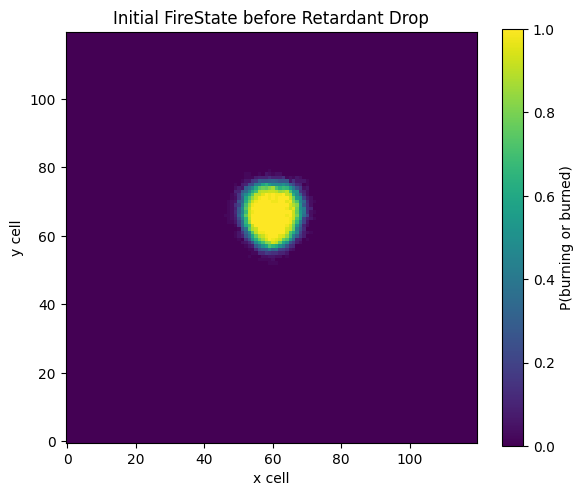

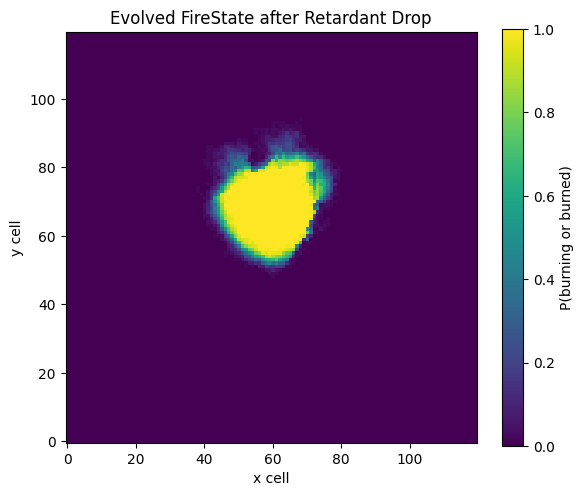

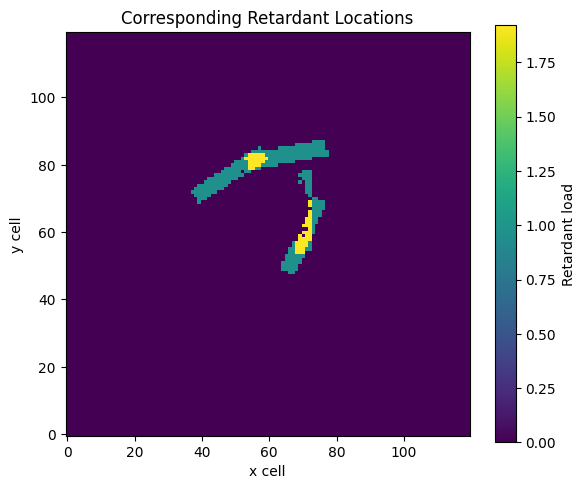

In [7]:
drop_opt.plot_evolved_firestate(
    theta=best_theta,
    n_sims=50,)

### Bayesian Optimisation (Heuristic + Random Initialisation)

In [8]:
search_mask, coords = drop_opt.setup_search_grid(K=300, boundary_field="affected")
best_theta, best_params, best_value, (X, y), y_nexts, y_bests = drop_opt.run_bayes_opt(
    n_init=50,
    n_iters=150,
    n_candidates=2**12,
    xi=0.01, 
    verbose=True,
    init_strategy="heuristic",
    init_heuristic_random_frac=0.3, #% of initial points that are random (the rest are heuristic initialised)
    print_every=10,
    candidate_strategy="qmc",
    candidate_qmc="sobol",
)

[BO] init: n_init=50, dim=12, n_cells=529
[BO] init: best_y=1.2108, mean_y=1.378, std_y=0.120812
[BO] iter 001/150 | y_next=1.44097 | best_y=1.2108 (no-improve) | EI_max=0.013 | mu=1.27925 | std=0.102
      proposed (x,y,phi) per drone:
      [[44.         71.          3.18193089]
 [52.         86.          5.77577472]
 [74.         80.          4.44809828]
 [75.         70.          5.10041437]]
      gp.kernel_ = 1.12**2 * TiedXYFiMatern(lx=597, ly=0.144, lphi=1.61, nu=2.5) + WhiteKernel(noise_level=0.0498)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 010/150 | y_next=1.61878 | best_y=1.2108 (no-improve) | EI_max=0.00662 | mu=1.35735 | std=0.127
      proposed (x,y,phi) per drone:
      [[63.         53.          3.24328328]
 [72.         83.          4.07519707]
 [74.         80.          5.36743013]
 [75.         71.          0.13042823]]
      gp.kernel_ = 1.08**2 * TiedXYFiMatern(lx=0.186, ly=0.156, lphi=1.29, nu=2.5) + WhiteKernel(noise_level=0.0247)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/si

[BO] iter 020/150 | y_next=1.51941 | best_y=1.2108 (no-improve) | EI_max=0.00834 | mu=1.33549 | std=0.122
      proposed (x,y,phi) per drone:
      [[45.         66.          1.59751686]
 [62.         77.          1.56068446]
 [65.         78.          2.65722177]
 [72.         83.          4.60561333]]
      gp.kernel_ = 1.06**2 * TiedXYFiMatern(lx=0.0886, ly=0.0735, lphi=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/si

[BO] iter 030/150 | y_next=1.50601 | best_y=1.2108 (no-improve) | EI_max=0.0021 | mu=1.40088 | std=0.117
      proposed (x,y,phi) per drone:
      [[51.         57.          2.78923474]
 [51.         82.          4.22972578]
 [72.         83.          5.71751667]
 [75.         70.          0.2274557 ]]
      gp.kernel_ = 0.985**2 * TiedXYFiMatern(lx=0.0856, ly=0.114, lphi=1.22, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/si

[BO] iter 040/150 | y_next=1.43045 | best_y=1.2108 (no-improve) | EI_max=0.00175 | mu=1.3959 | std=0.111
      proposed (x,y,phi) per drone:
      [[45.         66.          3.11358461]
 [45.         79.          5.14937268]
 [52.         86.          4.42418551]
 [68.         84.          6.20554419]]
      gp.kernel_ = 0.953**2 * TiedXYFiMatern(lx=12.2, ly=0.0695, lphi=0.953, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/si

[BO] iter 050/150 | y_next=1.45997 | best_y=1.2108 (no-improve) | EI_max=0.00126 | mu=1.39539 | std=0.104
      proposed (x,y,phi) per drone:
      [[45.         66.          3.80431996]
 [49.         79.          4.31618833]
 [50.         85.          4.76347956]
 [75.         70.          0.10020805]]
      gp.kernel_ = 0.93**2 * TiedXYFiMatern(lx=0.0952, ly=0.0764, lphi=0.979, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/si

[BO] iter 060/150 | y_next=1.46753 | best_y=1.2108 (no-improve) | EI_max=0.000758 | mu=1.4226 | std=0.107
      proposed (x,y,phi) per drone:
      [[47.         82.          0.14850963]
 [58.         77.          6.04024903]
 [69.         85.          0.14726846]
 [75.         74.          4.09843054]]
      gp.kernel_ = 0.944**2 * TiedXYFiMatern(lx=0.0834, ly=0.0663, lphi=1.43, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/si

[BO] iter 070/150 | y_next=1.59622 | best_y=1.2108 (no-improve) | EI_max=0.000549 | mu=1.43547 | std=0.107
      proposed (x,y,phi) per drone:
      [[49.         84.          4.27650273]
 [54.         55.          0.84745472]
 [55.         76.          1.04003936]
 [63.         53.          0.98617895]]
      gp.kernel_ = 0.954**2 * TiedXYFiMatern(lx=0.0852, ly=0.0632, lphi=1.66, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/si

[BO] iter 080/150 | y_next=1.52816 | best_y=1.2108 (no-improve) | EI_max=0.000251 | mu=1.46628 | std=0.108
      proposed (x,y,phi) per drone:
      [[52.         86.          2.74894327]
 [54.         75.          5.84972741]
 [58.         87.          2.27847606]
 [58.         87.          4.63802748]]
      gp.kernel_ = 1.9**2 * TiedXYFiMatern(lx=0.314, ly=0.362, lphi=12.1, nu=2.5) + WhiteKernel(noise_level=0.34)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/si

[BO] iter 090/150 | y_next=1.49972 | best_y=1.2108 (no-improve) | EI_max=0.000873 | mu=1.39497 | std=0.098
      proposed (x,y,phi) per drone:
      [[48.         60.          3.67931062]
 [57.         81.          5.51781358]
 [58.         84.          5.9923765 ]
 [75.         76.          5.66271549]]
      gp.kernel_ = 0.944**2 * TiedXYFiMatern(lx=0.083, ly=0.0714, lphi=1.35, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/si

[BO] iter 100/150 | y_next=1.37694 | best_y=1.2108 (no-improve) | EI_max=0.000283 | mu=1.39392 | std=0.0831
      proposed (x,y,phi) per drone:
      [[50.         85.          3.57899694]
 [60.         79.          5.09132416]
 [63.         87.          5.52796211]
 [72.         83.          0.09394155]]
      gp.kernel_ = 1.6**2 * TiedXYFiMatern(lx=0.264, ly=0.346, lphi=9.74, nu=2.5) + WhiteKernel(noise_level=0.404)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 110/150 | y_next=1.6008 | best_y=1.2108 (no-improve) | EI_max=0.000115 | mu=1.46711 | std=0.0996
      proposed (x,y,phi) per drone:
      [[52.         86.          3.42891834]
 [63.         53.          5.99249422]
 [69.         85.          5.36152524]
 [72.         60.          5.07496765]]
      gp.kernel_ = 1.59**2 * TiedXYFiMatern(lx=0.259, ly=0.332, lphi=8.23, nu=2.5) + WhiteKernel(noise_level=0.384)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 120/150 | y_next=1.47354 | best_y=1.2108 (no-improve) | EI_max=0.000107 | mu=1.45354 | std=0.0943
      proposed (x,y,phi) per drone:
      [[44.         77.          2.77559294]
 [58.         87.          5.18858807]
 [61.         53.          4.16581141]
 [69.         85.          3.98888356]]
      gp.kernel_ = 1.45**2 * TiedXYFiMatern(lx=0.237, ly=0.296, lphi=6.96, nu=2.5) + WhiteKernel(noise_level=0.372)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 130/150 | y_next=1.62094 | best_y=1.2108 (no-improve) | EI_max=0.000647 | mu=1.41258 | std=0.101
      proposed (x,y,phi) per drone:
      [[57.         77.          6.2796452 ]
 [67.         77.          5.49628927]
 [73.         61.          4.46069712]
 [74.         65.          5.78154557]]
      gp.kernel_ = 1.03**2 * TiedXYFiMatern(lx=0.104, ly=0.0731, lphi=2.31, nu=2.5) + WhiteKernel(noise_level=1e-06)
[BO] iter 140/150 | y_next=1.50625 | best_y=1.2108 (no-improve) | EI_max=0.000119 | mu=1.43995 | std=0.0908
      proposed (x,y,phi) per drone:
      [[47.         82.          4.24868423]
 [61.         77.          5.68844522]
 [62.         56.          4.33567021]
 [64.         86.          3.94426756]]
      gp.kernel_ = 1.29**2 * TiedXYFiMatern(lx=0.226, ly=0.273, lphi=5.26, nu=2.5) + WhiteKernel(noise_level=0.391)
[BO] iter 150/150 | y_next=1.51226 | best_y=1.2108 (no-improve) | EI_max=4.32e-05 | mu=1.43869 | std=0.0818
      proposed (x,y,phi) per drone:
      [[47

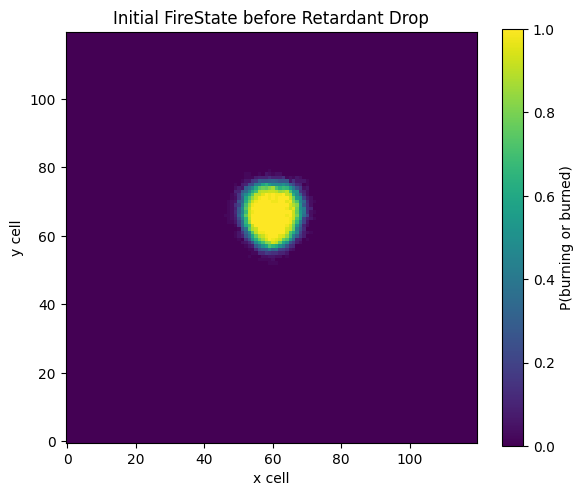

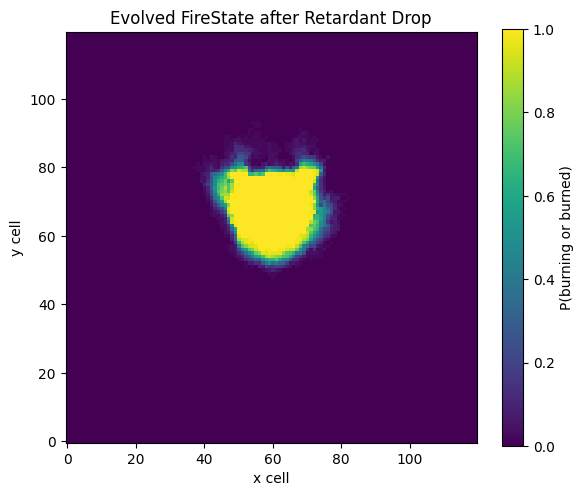

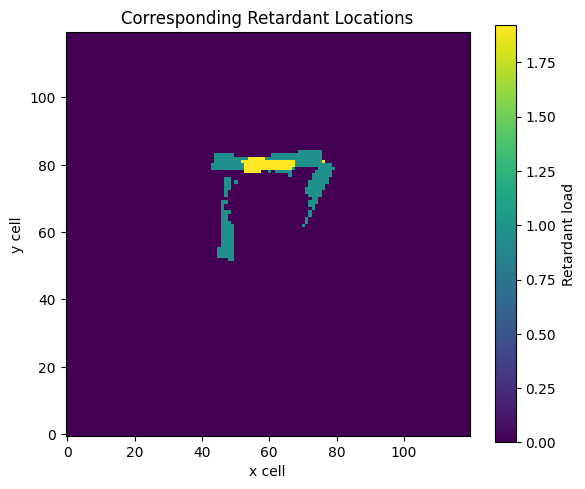

In [9]:
drop_opt.plot_evolved_firestate(
    theta=best_theta,
    n_sims=50,)

### Heuristic + Local Exploitation

In [10]:
search_mask, coords = drop_opt.setup_search_grid(K=300, boundary_field="affected")
best_theta, best_params, best_value, (X, y), y_nexts, y_bests = drop_opt.run_bayes_opt(
    n_init=50,
    n_iters=150,
    n_candidates=2**12, #note will still hit the Sobol balance property warning since Sobol used for global (so n_candidates*(1-candidate_local_frac) should be power of 2)
    xi=0.01, 
    verbose=True,
    init_strategy="heuristic",
    init_heuristic_random_frac=0.3, #% of initial points that are random (the rest are heuristic initialised)
    print_every=10,
    candidate_strategy="mixed",
    candidate_qmc="sobol",
    candidate_local_frac=0.6,
    candidate_local_top_k=5,
    candidate_local_sigma_cells=4.0,
    candidate_local_sigma_phi_rad=np.deg2rad(20),
)

[BO] init: n_init=50, dim=12, n_cells=529
[BO] init: best_y=1.21649, mean_y=1.40305, std_y=0.114741


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lx is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)


[BO] iter 001/150 | y_next=1.27441 | best_y=1.21649 (no-improve) | EI_max=0.0408 | mu=1.17736 | std=0.0587
      proposed (x,y,phi) per drone:
      [[45.         66.          3.37410746]
 [58.         83.          5.03018136]
 [68.         82.          4.6048577 ]
 [71.         70.          6.06705686]]
      gp.kernel_ = 1.13**2 * TiedXYFiMatern(lx=0.354, ly=1e+03, lphi=1.04, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lx is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lphi is close

[BO] iter 010/150 | y_next=1.28285 | best_y=1.21649 (no-improve) | EI_max=0.0105 | mu=1.25445 | std=0.0708
      proposed (x,y,phi) per drone:
      [[45.         78.          4.20447536]
 [50.         65.          3.82020993]
 [50.         79.          4.83099671]
 [62.         80.          4.61709364]]
      gp.kernel_ = 1.11**2 * TiedXYFiMatern(lx=0.166, ly=0.0907, lphi=1.89, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lphi is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lphi is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/D

[BO] iter 020/150 | y_next=1.35094 | best_y=1.20302 (no-improve) | EI_max=0.00632 | mu=1.26163 | std=0.0711
      proposed (x,y,phi) per drone:
      [[51.         80.          4.79459211]
 [57.         77.          5.33842662]
 [61.         85.          4.98503377]
 [69.         65.          6.06379083]]
      gp.kernel_ = 1.1**2 * TiedXYFiMatern(lx=0.159, ly=0.119, lphi=2.7, nu=2.5) + WhiteKernel(noise_level=0.118)


/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points requ

[BO] iter 030/150 | y_next=1.16354 | best_y=1.16354 (improved) | EI_max=0.00734 | mu=1.1836 | std=0.0436
      proposed (x,y,phi) per drone:
      [[45.         71.          2.44818173]
 [59.         81.          5.06694811]
 [63.         81.          4.25971452]
 [75.         70.          0.33484303]]
      gp.kernel_ = 1.13**2 * TiedXYFiMatern(lx=0.131, ly=0.104, lphi=3.11, nu=2.5) + WhiteKernel(noise_level=0.0479)


/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points requ

[BO] iter 040/150 | y_next=1.18694 | best_y=1.15517 (no-improve) | EI_max=0.00372 | mu=1.20221 | std=0.0526
      proposed (x,y,phi) per drone:
      [[49.         68.          3.15480435]
 [58.         82.          4.96023768]
 [60.         81.          4.62606633]
 [75.         70.          0.41420473]]
      gp.kernel_ = 1.11**2 * TiedXYFiMatern(lx=0.159, ly=0.141, lphi=2.84, nu=2.5) + WhiteKernel(noise_level=0.111)


/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points requ

[BO] iter 050/150 | y_next=1.60806 | best_y=1.12931 (no-improve) | EI_max=0.00106 | mu=1.37969 | std=0.129
      proposed (x,y,phi) per drone:
      [[72.         83.          4.69809333]
 [72.         83.          5.45375117]
 [73.         61.          4.37986354]
 [74.         80.          0.93533528]]
      gp.kernel_ = 1.15**2 * TiedXYFiMatern(lx=0.224, ly=0.181, lphi=2.68, nu=2.5) + WhiteKernel(noise_level=0.109)


/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points requ

[BO] iter 060/150 | y_next=1.25674 | best_y=1.12542 (no-improve) | EI_max=0.0013 | mu=1.20539 | std=0.0561
      proposed (x,y,phi) per drone:
      [[45.         67.          3.45333524]
 [59.         79.          4.38450638]
 [60.         82.          4.02653072]
 [74.         66.          0.39353518]]
      gp.kernel_ = 1.21**2 * TiedXYFiMatern(lx=0.167, ly=0.178, lphi=3.88, nu=2.5) + WhiteKernel(noise_level=0.0823)


/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points requ

[BO] iter 070/150 | y_next=1.13997 | best_y=1.10316 (no-improve) | EI_max=0.00108 | mu=1.16703 | std=0.0463
      proposed (x,y,phi) per drone:
      [[45.         66.          3.20815033]
 [54.         79.          5.20890251]
 [61.         80.          4.72063583]
 [75.         71.          0.50150231]]
      gp.kernel_ = 1.2**2 * TiedXYFiMatern(lx=0.185, ly=0.151, lphi=3.56, nu=2.5) + WhiteKernel(noise_level=0.0596)


/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points requ

[BO] iter 080/150 | y_next=1.12899 | best_y=1.10271 (no-improve) | EI_max=0.000999 | mu=1.15835 | std=0.0414
      proposed (x,y,phi) per drone:
      [[45.         67.          2.70736139]
 [56.         80.          4.64265784]
 [59.         80.          4.86647926]
 [75.         70.          0.60015616]]
      gp.kernel_ = 1.2**2 * TiedXYFiMatern(lx=0.175, ly=0.156, lphi=3.71, nu=2.5) + WhiteKernel(noise_level=0.0497)


/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points requ

[BO] iter 090/150 | y_next=1.16319 | best_y=1.09309 (no-improve) | EI_max=0.00105 | mu=1.14711 | std=0.041
      proposed (x,y,phi) per drone:
      [[45.         67.          2.97649982]
 [56.         79.          5.21683316]
 [60.         82.          4.95310922]
 [75.         70.          0.54289627]]
      gp.kernel_ = 1.16**2 * TiedXYFiMatern(lx=0.169, ly=0.172, lphi=4.27, nu=2.5) + WhiteKernel(noise_level=0.0512)


/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points requ

[BO] iter 100/150 | y_next=1.62799 | best_y=1.09309 (no-improve) | EI_max=0.000648 | mu=1.48775 | std=0.176
      proposed (x,y,phi) per drone:
      [[63.         53.          6.16021038]
 [69.         85.          2.80600801]
 [72.         83.          1.02374518]
 [72.         83.          3.1791466 ]]
      gp.kernel_ = 1.16**2 * TiedXYFiMatern(lx=0.216, ly=0.141, lphi=3.59, nu=2.5) + WhiteKernel(noise_level=0.0331)


/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points requ

[BO] iter 110/150 | y_next=1.15271 | best_y=1.09309 (no-improve) | EI_max=0.000856 | mu=1.14235 | std=0.037
      proposed (x,y,phi) per drone:
      [[48.         69.          3.19339638]
 [57.         78.          4.71560548]
 [57.         80.          4.70480572]
 [71.         70.          0.47535294]]
      gp.kernel_ = 1.14**2 * TiedXYFiMatern(lx=0.215, ly=0.147, lphi=3.53, nu=2.5) + WhiteKernel(noise_level=0.0297)


/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points requ

[BO] iter 120/150 | y_next=1.19267 | best_y=1.09073 (no-improve) | EI_max=0.000426 | mu=1.15932 | std=0.0409
      proposed (x,y,phi) per drone:
      [[46.         70.          3.07954901]
 [59.         77.          4.59901856]
 [62.         78.          4.72712906]
 [69.         72.          0.22231458]]
      gp.kernel_ = 1.1**2 * TiedXYFiMatern(lx=0.188, ly=0.159, lphi=3.43, nu=2.5) + WhiteKernel(noise_level=0.0277)


/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points requ

[BO] iter 130/150 | y_next=1.11635 | best_y=1.08941 (no-improve) | EI_max=0.000473 | mu=1.13614 | std=0.0318
      proposed (x,y,phi) per drone:
      [[4.50000000e+01 6.80000000e+01 2.93750705e+00]
 [5.80000000e+01 7.90000000e+01 5.24358882e+00]
 [5.90000000e+01 7.90000000e+01 4.86300326e+00]
 [7.20000000e+01 7.30000000e+01 5.73253159e-02]]
      gp.kernel_ = 1.1**2 * TiedXYFiMatern(lx=0.174, ly=0.146, lphi=3.25, nu=2.5) + WhiteKernel(noise_level=0.0176)


/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points requ

[BO] iter 140/150 | y_next=1.54934 | best_y=1.08941 (no-improve) | EI_max=0.000241 | mu=1.51787 | std=0.168
      proposed (x,y,phi) per drone:
      [[48.         83.          1.74939003]
 [63.         53.          1.89717892]
 [63.         87.          4.98671689]
 [66.         55.          4.66115793]]
      gp.kernel_ = 1.06**2 * TiedXYFiMatern(lx=0.175, ly=0.145, lphi=3.27, nu=2.5) + WhiteKernel(noise_level=0.0152)


/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points requ

[BO] iter 150/150 | y_next=1.11413 | best_y=1.07427 (no-improve) | EI_max=0.0002 | mu=1.12524 | std=0.0293
      proposed (x,y,phi) per drone:
      [[45.         66.          3.01415755]
 [58.         80.          4.82990135]
 [60.         77.          4.60901125]
 [72.         71.          0.45873773]]
      gp.kernel_ = 1.02**2 * TiedXYFiMatern(lx=0.162, ly=0.151, lphi=3.24, nu=2.5) + WhiteKernel(noise_level=0.0156)
[BO] done: best_y=1.07427
[BO] best params:
[[47.         68.          3.22565395]
 [58.         79.          5.00547969]
 [59.         79.          4.60873582]
 [71.         71.          0.18811318]]


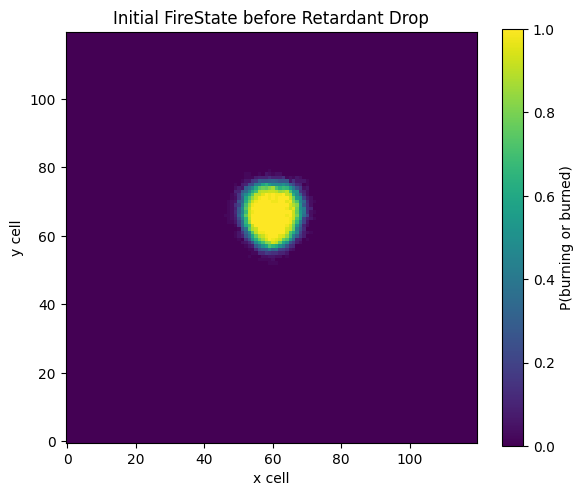

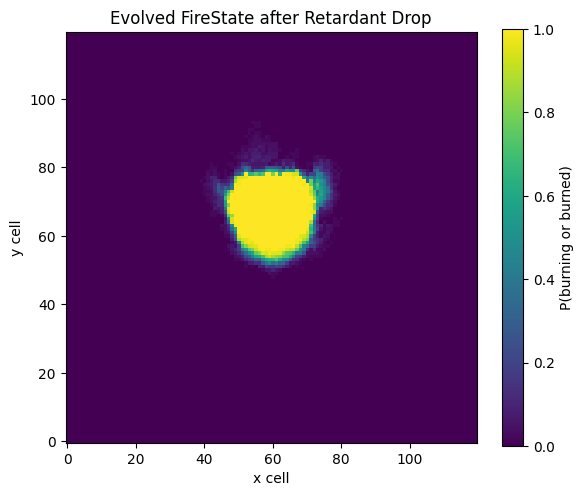

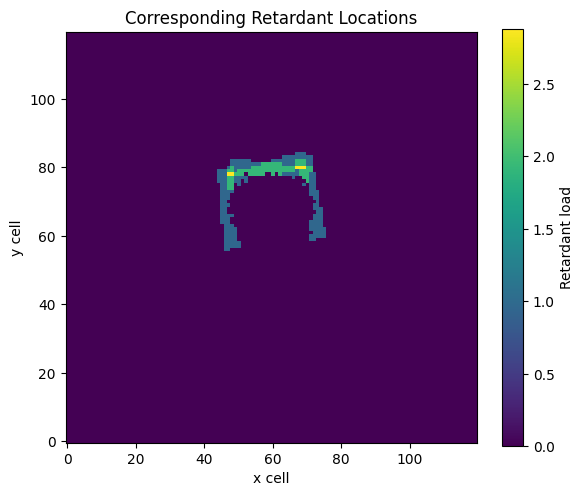

In [11]:
drop_opt.plot_evolved_firestate(
    theta=best_theta,
    n_sims=50,)